# Temple Artifact Removal Tool Validation

This notebook imports the artifact data from the Temple dataset. The dataset is imported and separated into `clean`, `eye`, and `mus` files; where `clean` is the clean data from the beginning of the trial, `eye` are the eye movement artifacts, and `mus` are the muscle artifacts, respectively. 

The dataset is then preprocessed, run through the artifact removal tool, and the EEG Quality Index is calculated. 

Notes
-----
- This notebook requires the `.npz` files exported from the [Import datasets](./01_Import_datasets.ipynb) notebook.
- Run each section of the notebook **separately**. Each section of code has some `settings` associated with the individual section.

In [1]:
#%% Import standard libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections

#%% Import custom libraries
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

# Import and segment data

- The `.npz` files are imported.
- The `eye` and `mus` variables are segmented in lists containing the individual artifacts

In [3]:
## Import data
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
all_files = os.listdir(path=data_folder)# List of subjects
os.chdir(notebook_dir)                  # Return to notebook directory

# - Select only .edf files and remove file extension
edf_files = [file.split('.')[0] for file in all_files if file.split('.')[-1] =='edf']

## Preallocate variables
n_files = len(edf_files)        # Number of files
clean_eeg = [None] * n_files    # Clean segment of EEG data [V] [n_channels x samples]
eye_eeg = [None] * n_files      # 
mus_eeg = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

## Select valid EEG channels
# - List of valid EEG channels to separate them from other types of data
eeg_valid_chans = np.array(['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                    'T3','T4','T5','T6','T1','T2','FZ','CZ','PZ'])
n_chans = len(eeg_valid_chans)

# - Select only the valid channels from each file
for f,file in enumerate(edf_files):
    # Load temporary data
    temp_file_name = data_folder + '\\' + file + '.npz'
    temp_data = np.load(temp_file_name, allow_pickle=True)
    
    # Get index of valid EEG channels
    chans[f] = temp_data['chans']   # List of all channels
    eeg_idx = np.zeros(np.size(eeg_valid_chans), dtype=int) # Temporary index for channels
    print(f'{file} file loaded')

    for ci,c in enumerate(eeg_valid_chans): # For channel_index in channel
        if np.size(np.where(chans[f]==c)) > 0:
            eeg_idx[ci] = (np.where(chans[f]==c)[0])

    eeg_idx = np.sort(eeg_idx)      # Sort list of channels
    chans[f] = chans[f][eeg_idx]    # Select only valid channels
    
    # Organize eye and muscle artifacts in tensors
    eye_artifacts = np.size(temp_data['eye_eeg'])
    eye_eeg[f] = [None] * eye_artifacts
    for eye in range(eye_artifacts):
        eye_eeg[f][eye] = temp_data['eye_eeg'][eye][eeg_idx,:]

    mus_artifacts = np.size(temp_data['mus_eeg'])
    mus_eeg[f] = [None] * mus_artifacts
    for mus in range(mus_artifacts):
        mus_eeg[f][mus] = temp_data['mus_eeg'][mus][eeg_idx,:]

    # Separate clean EEG and sampling rate
    clean_eeg[f] = temp_data['clean_eeg'][eeg_idx,:]    
    srate[f] = float(temp_data['srate'])
    
    del temp_data   # Delete temporary data from memory

00000254_s007_t000 file loaded
00000647_s002_t000 file loaded
00000768_s003_t000 file loaded


## Randomize artifact order

Randomize the order of the artifacts 

# Pre-process

Apply band-pass filter datasets. Plot filtered data if needed.

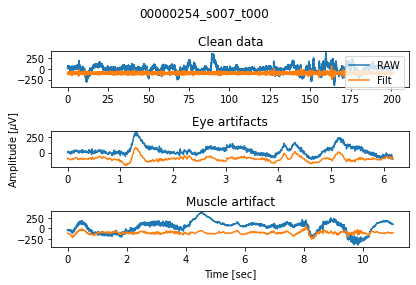

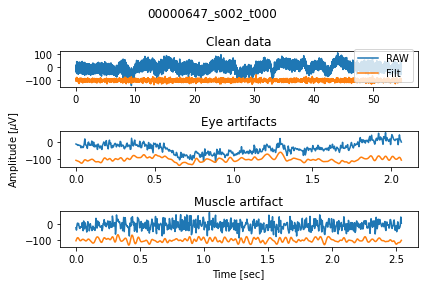

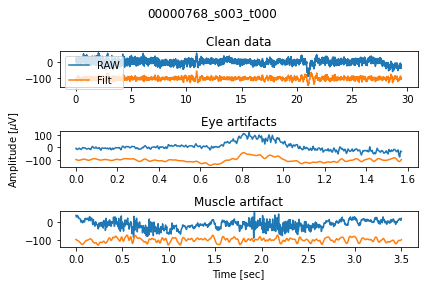

In [5]:
#%% Settings
# - Plot settings
plot = True    # Boolean to plot pre-processed data
scale = 1e6     # Scale for EEG data
offset = 100    # Offset for filtered data (after scaling)

# - Filter settings
fc = [1, 30]    # Cut-off frequencies [Hz]
f_type = "band" # Filter type
f_order = 4     # Filter order [n]

#%% Preallocate data
clean_pre_eeg = [None] * n_files
mus_pre_eeg =   [None] * n_files
eye_pre_eeg =   [None] * n_files

#%% Filter data
for f,file in enumerate(edf_files):
    clean_pre_eeg[f] = eeg_preprocessing.filter(f_type, clean_eeg[f], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(eye_eeg[f])
    eye_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        eye_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, eye_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(mus_eeg[f])
    mus_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        mus_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, mus_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    if plot:
        fig, ax = plt.subplots(3,1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Clean data")
        temp_time = np.linspace(0, np.max(np.shape(clean_eeg[f]))/srate[f], np.max(np.shape(clean_eeg[f])))
        ax[0].plot(temp_time, scale*clean_eeg[f][0,:], label="RAW")
        ax[0].plot(temp_time, scale*clean_pre_eeg[f][0,:] - offset, label="Filt")
        ax[0].legend()

        ax[1].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_eeg[f][0]))/srate[f], np.max(np.shape(eye_eeg[f][0])))
        ax[1].plot(temp_time, scale*eye_eeg[f][0][0,:], label="RAW")
        ax[1].plot(temp_time, scale*eye_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[1].set_ylabel("Amplitude [$\mu$V]")

        ax[2].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_eeg[f][0]))/srate[f], np.max(np.shape(mus_eeg[f][0])))
        ax[2].plot(temp_time, scale*mus_eeg[f][0][0,:], label="RAW")
        ax[2].plot(temp_time, scale*mus_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[2].set_xlabel("Time [sec]")

        del temp_time, artifacts
        plt.tight_layout()

# Artifact removal

Apply the [artifact removal tools](../Functions/artifact_removal_tools.py) to the pre-processed data.

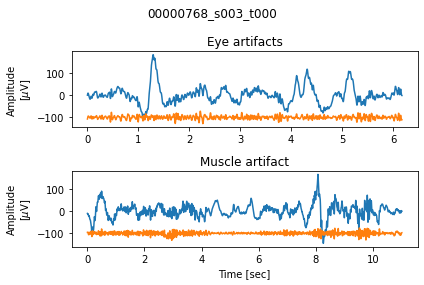

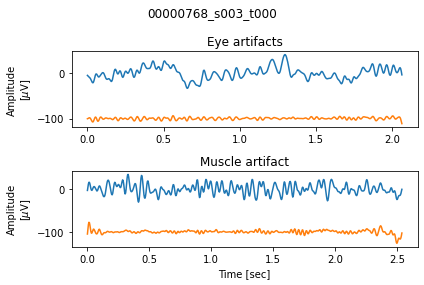

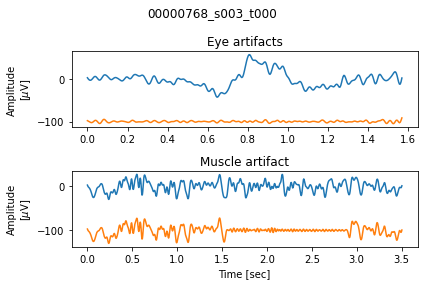

In [6]:
#%% Settings
# - Plot settings
plot = True     # Boolean to plot data without artifacts
scale = 1e6     # Scale for EEG data
offset = 100    # Offset for filtered data (after scaling)

# - ART settings
window_length = 0.9 # Window length for embedding matrix [sec]
n_clusters = 10     # Number of clusters for kmean classification [n]
n_artifacts = 3     # Number of artifacts trials to clean

#%% Preallocate data
eye_clean = [None] * n_files
mus_clean = [None] * n_files

#%% Apply ART
for f in range(n_files):
    # Preallocate variables
    eye_clean[f] = [None] * n_artifacts
    mus_clean[f] = [None] * n_artifacts

    for a in range(n_artifacts):
        [eye_clean[f][a],_,_] = art.remove_eyeblinks_cpu(
            eye_pre_eeg[f][a], 
            srate=srate[f],
            window_length=window_length,
            n_clusters=n_clusters)

        [mus_clean[f][a],_,_] = art.remove_eyeblinks_cpu(
            mus_pre_eeg[f][b], 
            srate=srate[f],
            window_length=window_length,
            n_clusters=n_clusters)

    if plot:
        fig, ax = plt.subplots(2, 1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_pre_eeg[f][0]))/srate[f], np.max(np.shape(eye_pre_eeg[f][0])))
        ax[0].plot(temp_time, scale*eye_pre_eeg[f][0][0,:], label="filt")
        ax[0].plot(temp_time, scale*eye_clean[f][0][0,:] - offset, label="clean")
        ax[0].set_ylabel("Amplitude\n[$\mu$V]")

        ax[1].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_pre_eeg[f][0]))/srate[f], np.max(np.shape(mus_pre_eeg[f][0])))
        ax[1].plot(temp_time, scale*mus_pre_eeg[f][0][0,:], label="filt")
        ax[1].plot(temp_time, scale*mus_clean[f][0][0,:] - offset, label="clean")
        ax[1].set_ylabel("Amplitude\n[$\mu$V]")
        ax[1].set_xlabel("Time [sec]")
        
        plt.tight_layout()
        del temp_time

# EEG Quality Index

Compute the [EEG Quality Index](../Functions/eeg_quality_index.py) of the artifact removed data with respect to the clean data.

In [41]:
np.shape(eye_clean[0])

(1, 21, 1543)

In [50]:
#%% Settings
# - Plot settings
plot = True     # Boolean to plot data without artifacts

# - EEG Quality Index settings
window_size = int(srate[0])  # Number of samples for sliding window [n]
slide = 1               # Number of samples to slide the sliding window [n]

#%% Pre-allocate variables
# # - Eye movement artifact
# ct_eye_raw = np.zeros((n_files, n_chans))       # Clean_total
# cp_eye_raw = np.zeros((n_files, 6, n_chans))    # Clean_percent
# eqi_eye_raw =  np.zeros((n_files, 6, n_chans))

def trim_to_window(data, axis, window):
    """
        Trims input 2D data to max multiple of window size along axis
    """
    data_length = np.size(data, axis)
    multiple_window = np.floor(data_length/window)
    trim_length = int(window * multiple_window)

    if axis == 0:
        trimmed_data = data[:trim_length,:]
    elif axis == 1:
        trimmed_data = data[:, :trim_length]

    return trimmed_data

trim_clean_eeg = trim_to_window(clean_pre_eeg[0], axis=1, window=window_size)
trim_eye_eeg_raw = trim_to_window(eye_eeg[0][1], axis=1, window=window_size)
trim_eye_eeg_pre = trim_to_window(eye_pre_eeg[0][1], axis=1, window=window_size)
trim_eye_eeg_art = trim_to_window(eye_clean[0][1], axis=1, window=window_size)

[ct_eye_raw, cp_eye_raw, eqi_eye_raw] = eeg_quality_index.scoring(
    clean_eeg = trim_clean_eeg,
    test_eeg = trim_eye_eeg_raw,
    srate_clean = window_size,
    srate_test = window_size,
    window = window_size,
    slide = slide)

[ct_eye_pre, cp_eye_pre, eqi_eye_pre] = eeg_quality_index.scoring(
    clean_eeg = trim_clean_eeg,
    test_eeg = trim_eye_eeg_pre,
    srate_clean = window_size,
    srate_test = window_size,
    window = window_size,
    slide = slide)

[ct_eye_art, cp_eye_art, eqi_eye_art] = eeg_quality_index.scoring(
    clean_eeg = trim_clean_eeg,
    test_eeg = trim_eye_eeg_art,
    srate_clean = window_size,
    srate_test = window_size,
    window = window_size,
    slide = slide)

# trim_clean_eeg = clean_eeg[0][:,window_size*np.floor(np.max(np.shape(clean_eeg[0]))/window_size)]
# trim_eye_eeg = eye_eeg[0][1][:, window_size*np.floor(np.max(np.shape(eye_eeg)))]


# #%% Compute EEG Quality Index

# f = 0
# [ct_eye_raw,_,eqi_eye_raw] = eeg_quality_index.scoring(clean_eeg[0], eye_eeg[0][2], srate[f], srate[f], window=srate[f], slide=1)
# [ct_eye_art,_,eqi_eye_art] = eeg_quality_index.scoring(clean_eeg[0], eye_clean[0][2], srate[f], srate[f], window=srate[f], slide=1)

## Visualize Quality Index

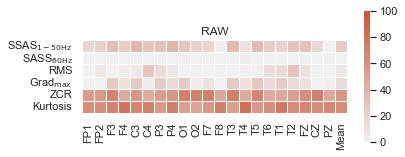

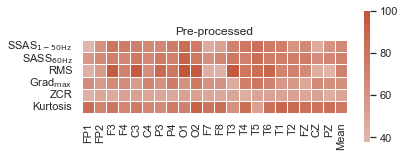

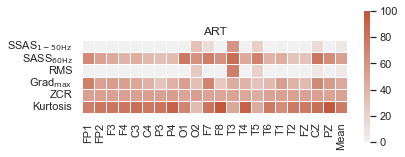

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:title={'center':'ART'}>)

In [51]:
eeg_quality_index.heatmap(cp_eye_raw, chans=eeg_valid_chans.tolist(), title="RAW")
eeg_quality_index.heatmap(cp_eye_pre, chans=eeg_valid_chans.tolist(), title="Pre-processed")
eeg_quality_index.heatmap(cp_eye_art, chans=eeg_valid_chans.tolist(), title="ART")